In [0]:
#Import libraries
import random
import numpy as np
from copy import deepcopy
from math import ceil, floor
import matplotlib.pyplot as plt


In [0]:


class crowd_egress():
  """
  people: Integer, specifies the number of people in the room
  room_dim: Tuple of two integers, specifies the dimensions of the room
  e.g. (20,10) = 20 meters width, 10 meters length
  exits: Integer, specifies the number of exits in the room
  exit_size: Integer, specifies the size of each exit in the room
  """

  def __init__(self,people, room_dim, exits, exit_size):
    self.people = people
    self.room_dim = room_dim
    self.exits = exits
    self.exit_size = exit_size
    self.room = [[0 for x in range(room_dim[0])] for x in range(room_dim[1])]
    #stores exit locations
    self.exit_loc = []
    self.exit_mids = []

  #Function to initialize the simulation
  #Initialize people to a 1 while empty spots in the room are a 0
  def initialize(self):

    count = 0

    #While loop for the case where we randomly choose the same spot to assign
    #people
    while count != self.people:
      row = random.randint(0,self.room_dim[1]-1)
      column = random.randint(0,self.room_dim[0]-1)

      if self.room[row][column] != 1:
        self.room[row][column] = 1
        count+= 1
      
    #initialize exits
    for i in range(self.exits):
        
      placed = False
      while placed == False:
        
        
        #choose one of the four walls to place an exit on
        #1 = north wall, 2 = east wall, 3 = south wall, 4 = west wall
        wall = random.randint(1,4)
        if wall == 1 or wall == 3:
          start_point = random.randint(0,self.room_dim[0]-self.exit_size)

          #Check if an exit already exists at those points
          #If it does then run the loop again
          exist = False
          if wall == 1:
            for coordinates in self.exit_loc:
              for i in range(start_point,start_point+self.exit_size):
                if (0,i) == coordinates:
                  exist = True
                  break
              if exist == True:
                break
            if exist == True:            
              continue
          else:
            for coordinates in self.exit_loc:
              for i in range(start_point,start_point+self.exit_size):
                if (self.room_dim[1]-1,i) == coordinates:
                  exist = True
                  break
              if exist == True:
                break
            if exist == True:            
              continue


        elif wall == 2 or wall == 4:
          start_point = random.randint(0,self.room_dim[1]-self.exit_size)
          #Check if an exit already exists at those points
          #If it does then run the loop again
          exist = False
          if wall == 2:
            for coordinates in self.exit_loc:
              for i in range(start_point,start_point+self.exit_size):
                if (i,self.room_dim[0]-1) == coordinates:
                  exist = True
                  break
              if exist == True:
                break
            if exist == True:            
              continue
          else:
            for coordinates in self.exit_loc:
              for i in range(start_point,start_point+self.exit_size):
                if (i,0) == coordinates:
                  exist = True
                  break
              if exist == True:
                break
            if exist == True:            
              continue


        #Make exits relative to the wall chosen
        if wall == 1:
          for i in range(self.exit_size):
            self.exit_loc.append((0,start_point+i))
          placed = True  
          continue
        if wall == 2:
            for i in range(self.exit_size):
              self.exit_loc.append((start_point+i,self.room_dim[0]-1))
            placed = True  
            continue
        if wall == 3:
            for i in range(self.exit_size):
              self.exit_loc.append((self.room_dim[1]-1,start_point+i))
            placed = True
            continue
        if wall == 4:
            for i in range(self.exit_size):
              self.exit_loc.append((start_point+i,0))
            placed = True 
            continue

    #Calculate the mid point of each gate for mahalanobis distance
    for i in range(0,len(self.exit_loc),self.exit_size):
      self.exit_mids.append(np.mean(self.exit_loc[i:i+self.exit_size], axis=0))

    #In the case of an even sized exit, randomly choose one of the middle
    #points to be the middle one
    for j in range(len(self.exit_mids)):
      if random.random() < 0.5:
        self.exit_mids[j][0] = ceil(self.exit_mids[j][0])
        self.exit_mids[j][1] = ceil(self.exit_mids[j][1])
      else:
        self.exit_mids[j][0] = floor(self.exit_mids[j][0])
        self.exit_mids[j][1] = floor(self.exit_mids[j][1]) 

    return(self.room)     
        



  #Update the simulation by one time step
  def update(self):
    
    #Copy current state to have an intermediate state
    next_step = deepcopy(self.room)

    #Get coordinates of each person
    ppl = np.where(np.array(self.room)==1)

    

    #Check if anyone is on the exit location so we can show they exited
    #in the next step
    for i in range(len(ppl[0])):
      if (ppl[0][i],ppl[1][i]) in self.exit_loc:
        next_step[ppl[0][i]][ppl[1][i]] = 0
        self.room[ppl[0][i]][ppl[1][i]] = 0


    distances = []
    #Calculate mahalanobis distance for each person
    for i in range(len(ppl[0])):
      one_person = []
      for x in self.exit_mids:
        
        #Calculate cost to each gate. Cost is +1 per person on the route
        cost = 0

        if ppl[0][i] - x[0] < 0:
          step = 1
        else:
          step = -1 

        if ppl[1][i] - x[1] < 0:
          step1 = 1
        else:
          step1 = -1     

        #Calculate the cost of moving vertically
        for j in range(ppl[0][i],int(x[0]),step):
          if step == 1:
            if self.room[j+1][ppl[1][i]] == 1:
              cost += 1
          else:
              self.room[j-1][ppl[1][i]] == 1
              cost += 1

        #Calculate the cost of moving horizontally
        for j in range(ppl[1][i],int(x[1]),step1):
          if step1 == 1:
            if self.room[int(x[0])][j+1] == 1:
              cost += 1   
          else:
            if self.room[int(x[0])][j-1] == 1:
              cost += 1            
        #Appends the coordinates of the person and their MH distance + cost
        #to each wall + wall coordinates
        one_person.append((ppl[0][i],ppl[1][i], abs(ppl[0][i]-x[0])+
                                                    abs(ppl[1][i]-x[1])+
                                                    cost,(x[0],x[1])))
      distances.append(one_person)

      #Choose which direction to move in by sorting according the list according
      #to MH distance, and just keep the first item
      directions = []
      for i in range(len(distances)):
        directions.append(sorted(distances[i])[0])


              
    #print(self.exit_mids)
    #print(self.exit_loc)
    #print(len(distances))
    #print(next_step)

    optimal_moves = []

    for i in directions:
      #If conditions to check which wall we are going to
      #wall 1
      if i[3][0] == 0:
        #check if vertical movement is possible
        if i[0]-1 >= 0:
          if self.room[i[0]-1][i[1]] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0]-1,i[1])))
        
        #check direction of horizontal movement
        
        #move left
        elif i[1]-i[3][1] > 0:
          if self.room[i[0]][i[1]-1] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0],i[1]-1)))
          
        #move right
        elif i[1]-i[3][1] < 0:
          if self.room[i[0]][i[1]+1] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0],i[1]+1)))

        #don't move if the exit is straight ahead of you 
          

      #wall 3
      elif i[3][0] == self.room_dim[1]-1:
      #check if vertical movement is possible
        if i[0]+1 <= self.room_dim[1]-1:
          if self.room[i[0]+1][i[1]] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0]+1,i[1])))
        
        #check direction of horizontal movement
        
        #move left
        elif i[1]-i[3][1] > 0:
          if self.room[i[0]][i[1]-1] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0],i[1]-1)))
          
        #move right
        elif i[1]-i[3][1] < 0:
          if self.room[i[0]][i[1]+1] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0],i[1]+1)))

      #wall 4
      elif i[3][1] == 0:
        #check if horizontal movement is possible
        if i[1]-1 >= 0:
          if self.room[i[0]][i[1]-1] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0],i[1]-1)))
        
        #check direction of vertical movement
        
        #move up
        elif i[0]-i[3][0] > 0:
          if self.room[i[0]-1][i[1]] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0]-1,i[1])))
          
        #move down
        elif i[0]-i[3][0] < 0:
          if self.room[i[0]+1][i[1]] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0]+1,i[1])))

        

      #wall 2  
      elif i[3][1] == self.room_dim[0]-1:
        #check if horizontal movement is possible
        if i[1]+1 <= self.room_dim[0]-1:
          if self.room[i[0]][i[1]+1] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0],i[1]+1)))
        
        #check direction of vertical movement
        
        #move up
        elif i[0]-i[3][0] > 0:
          if self.room[i[0]-1][i[1]] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0]-1,i[1])))
          
        #move down
        elif i[0]-i[3][0] < 0:
          if self.room[i[0]+1][i[1]] == 0:
            optimal_moves.append(((i[0],i[1]),(i[0]+1,i[1])))
    
    #check if more than one person has the same optimal move and randomly choose
    #one person to move
    optimal = [i[1] for i in optimal_moves]
    unique = set(optimal)
    indices = []
    for i in unique:
      index = []
      for j in range(len(optimal)):
        if optimal[j] == i:
          index.append(j)
      indices.append(index)
    
    #get rid of the indices which are duplicates randomly
    for i in range(len(indices)):
      while(len(indices[i])>1):
        indices[i].remove(random.choice(indices[i]))
    #Update next state
    for i in indices:
      next_step[optimal_moves[i[0]][0][0]][optimal_moves[i[0]][0][1]] = 0
      next_step[optimal_moves[i[0]][1][0]][optimal_moves[i[0]][1][1]] = 1

    self.room = deepcopy(next_step)





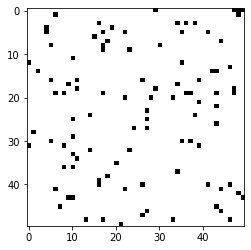

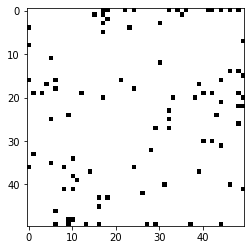

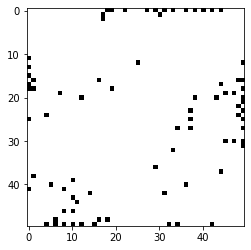

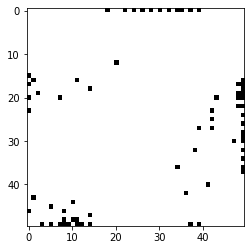

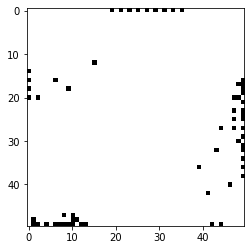

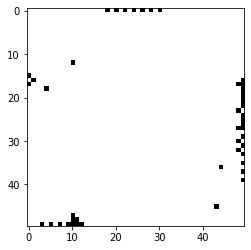

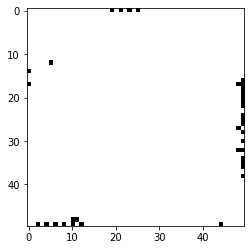

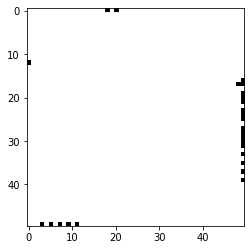

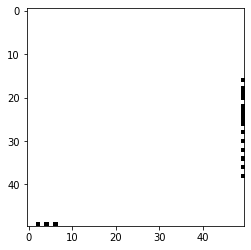

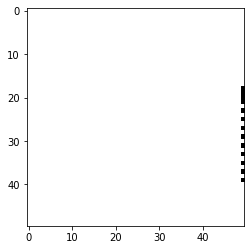

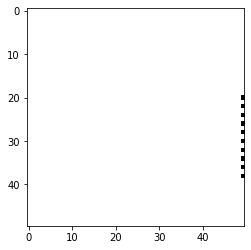

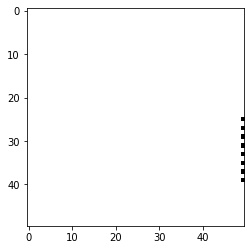

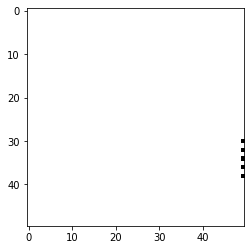

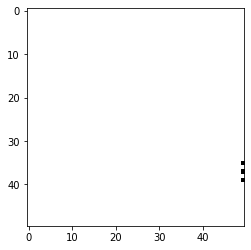

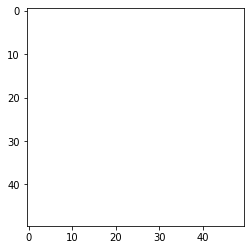

In [11]:
simulation = crowd_egress(100,(50,50),8,1)
simulation.initialize()
j=0
while np.count_nonzero(simulation.room) != 0:
        if j % 5 == 0:
          plt.imshow(simulation.room, cmap="Greys", interpolation="nearest")
          plt.show()
        j += 1
        simulation.update()
plt.imshow(simulation.room, cmap="Greys", interpolation="nearest")
plt.show()


In [0]:
#Cell to simulate different parameter settings for comparison

"""
#Simulate different settings
all_times = []
settings = []

#symmetrical rooms being tested
dimensions = [x for x in range(20,61,10)]
people = [x for x in range(10,211,40)]

for dim in dimensions:
  for ppl in people:
    time = []
    for i in range(1000):
      time_taken = 0
      x = crowd_egress(ppl,(dim,dim),4,2)
      x.initialize()
      #j = 0
      while np.count_nonzero(x.room) != 0:
        #j += 1
        #if j % 10 == 0:
        #  plt.imshow(x.room, cmap="Greys", interpolation="nearest")
        #  plt.show()
        x.update()
        time_taken += 1
      time.append(time_taken) 
    all_times.append(time) 
    settings.append((ppl,(dim,dim),4,2))   
"""